In [12]:
#The goal is to train a neural network that is able to recognize hans witen digits (mnist 28x28 pixel digits) 
#and to convert the model so that it can be used with tensorflow lite on a microcontroller.
# I am using an ESP32, and due to memory limitations, I had to simplifiy the neurel network so 
#that the model fits in ram.
#This code comes from google examples with some modifications
#it generates a .h file that contains the model data as an unsigend int array.
#this header file can be used in the ESP32 project. You must add "const" before "unsigned int"
#to put the data in flash memory rather than in RAM.

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random

print(tf.__version__)

2.2.0-rc3


In [13]:
# Keras provides a handy API to download the MNIST dataset, and split them into
# "train" dataset and "test" dataset.
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [14]:
# Normalize the input image so that each pixel value is between 0 to 1.
train_images = np.float32(train_images / 255.0)
test_images = np.float32(test_images / 255.0)
print('Pixels are normalized')

Pixels are normalized


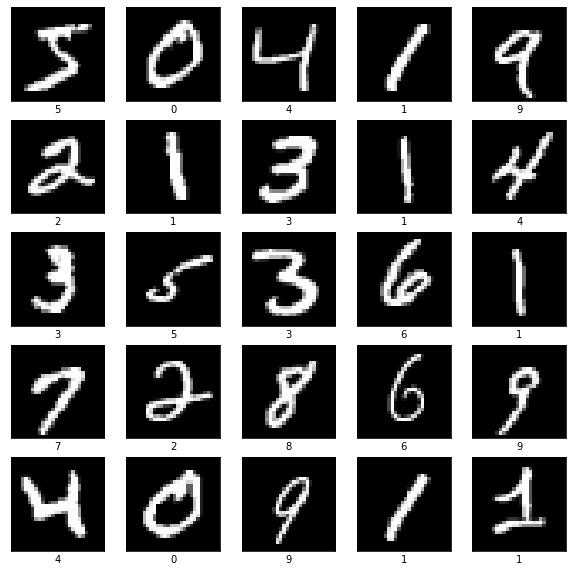

In [15]:
## Show the first 25 images in the training dataset.
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

In [26]:
# Define the model architecture
#the model has been simplified compared t the original example from google Conv2D layers have only 16 an 32 filters 
#instead of 32 and 64.
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Dropout(0.25),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])
# Define how to train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the digit classification model
model.fit(train_images, train_labels, epochs=5)

Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1918 - accuracy: 0.9430
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0664 - accuracy: 0.9796
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0499 - accuracy: 0.9844
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0395 - accuracy: 0.9872
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0331 - accuracy: 0.9892
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0297 - accuracy: 0.9900
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0259 - accuracy: 0.9914
Epoch 8/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0233 - accuracy: 0.9925
Epoch 9/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0212 - accuracy: 0.9931
Epoch 10/10
1875/1875 [==============================] - 12s 6ms/step - l

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

In [28]:
# Evaluate the model using all images in the test dataset.
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

313/313 [==============================] - 0s 1ms/step - loss: 0.0373 - accuracy: 0.9886
Test accuracy: 0.9886000156402588


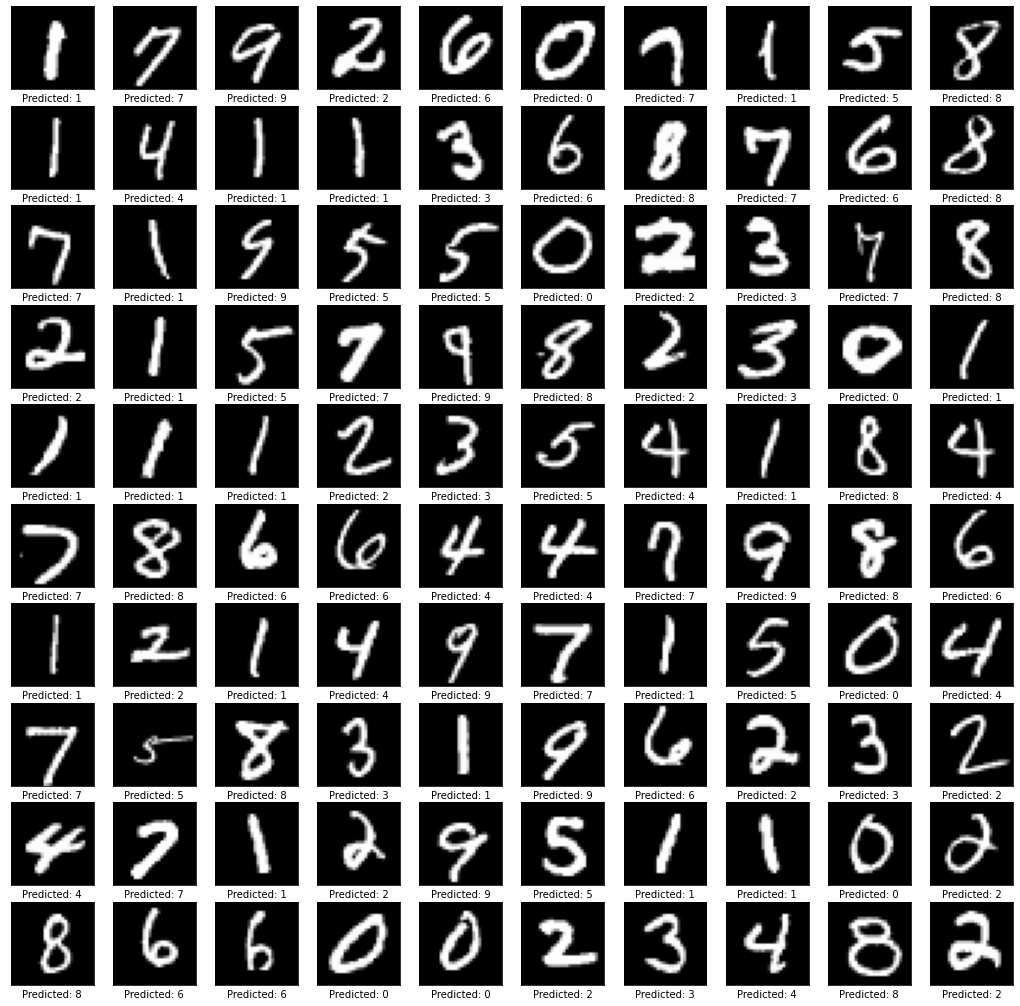

In [19]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Predict the labels of digit images in our test dataset.
predictions = model.predict(test_images)

# As the model output 10 float representing the probability of the input image
# being a digit from 0 to 9, we need to find the largest probability value
# to find out which digit the model predicts to be most likely in the image.
prediction_digits = np.argmax(predictions, axis=1)

# Then plot 100 random test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(18, 18))
for i in range(100):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_index = random.randint(0, len(prediction_digits))
  plt.imshow(test_images[image_index], cmap=plt.cm.gray)
  ax.xaxis.label.set_color(get_label_color(prediction_digits[image_index],\
                                           test_labels[image_index]))
  plt.xlabel('Predicted: %d' % prediction_digits[image_index])
  plt.imsave("sampledigit"+str(i)+".png",test_images[image_index],format=""'png'"",cmap=plt.cm.gray)
  with open("sampledigit" + str(i) + '.h', 'w') as file:
        file.write("float input[]={")
        for x in range(28):
            file.write("\n")
            for y in range (28):
                 file.write(str(test_images[image_index][x][y]))
                 if (x != 27) or (y != 27) :
                    file.write(" , ")
        file.write("};\n")
                    
plt.show()


In [20]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)
print (train_images[0].dtype)

Float model size = 201KBs.
float32


In [21]:


# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

'''def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    # Get sample input data as a numpy array in a method of your choosing.
    yield [input]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
converter.inference_input_type = tf.float32  # or tf.uint8
converter.inference_output_type = tf.float32  # or tf.uint8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
'''
def representative_dataset():
  for i in range(1):
    yield [train_images[i:i+1]]
converter.representative_dataset = representative_dataset
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))


Quantized model size = 54KBs,
which is about 27% of the float model size.


In [22]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

# Evaluate the TF Lite float model. You'll find that its accurary is identical
# to the original TF (Keras) model because they are essentially the same model
# stored in different format.
float_accuracy = evaluate_tflite_model(tflite_float_model)
print('Float model accuracy = %.4f' % float_accuracy)

# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)
quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
print('Accuracy drop = %.4f' % (float_accuracy - quantized_accuracy))

Float model accuracy = 0.9890
Quantized model accuracy = 0.9888
Accuracy drop = 0.0002


In [23]:
# Save the quantized model to file to the Downloads directory
f = open('mnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the digit classification model
#from google.colab import files
#files.download('mnist.tflite')

#print('`mnist.tflite` has been downloaded')

In [24]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str


In [25]:
tflite_model_name = 'mnist'  # Will be given .tflite suffix
c_model_name = 'mnist'       # Will be given .h suffix
with open(tflite_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_quantized_model, c_model_name))
